<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=500 height=300 align=center class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3 - Hunting using Bayes Nets  <br>
<font color=696880 size=4>
Ali Nazari


# Personal Data

In [1]:
# Set your student number and name
student_number = 401106266
Name = "Mahdi"
Last_Name = "AliNejad"

<font color="red">
It is highly recommended to do and run the exercise on colab. Otherwise, the graphics display may have problems.
</font>

# Q2: Hunting using Bayes Nets  (100 Points)

# Introduction

In this question, you should assist the bear in locating the deer on the map. The bear is unaware of the specific cell where the deer is located, but each cell contains probabilities and evidence. By leveraging these factors, the bear can make a good guess about the deer's whereabouts. Therefore, your task is to aid the bear in finding its food. As you may know, deer are fond of lettuce, and the presence of lettuce in an area depends on the presence of a warm air mass and Masai giraffes. Warm air can accelerate the growth of lettuce, and Masai giraffes consume lettuce. Additionally, the presence of deer in a location is contingent upon the likelihood of other hunters being present. Ultimately, based on these factors, the bear can estimate the probability of deer presence on each side. The complete graph is like this:

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1sB3zFmmywkVH-0lyp2QzNgqLJLsvKcfm' />
<figcaption>Graph</figcaption></center>
</figure>

All nodes operate in binary mode. For each cell, we will provide you with the graph and CPTs in full detail, and you should determine the direction in which the bear should move. You should initially solve the question using the variable elimination approach. Now, we will outline the format of the graph. For variable elimination, you should complete the "variable_elimination" function. The input of this function will be the input graph, and the output should be "left," "right," "up," or "down". The input is a dictionary, and here is an example of it:

<center>
{"1": {"parents": [ ], "CPT": [0.8]}, ..., "6": {"parents": [3, 4], "CPT": [0.66, 0.52, 0.31, 0.823]}, "observed": {"1": true, "3": true}}
</center>

So, there are 6 keys from 1 to 6, each with "parents" and "CPT". The "parents" key is a list of integers indicating the node's parents. The "CPT" key represents the Conditional Probability Table for each node and its probabilities. For probabilities, we provide only positive conditions, and you can easily infer the negative situations. For nodes with two parents, such as nodes 5 and 6, the first number represents when both parents are positive, the second number when the parent with the lower ID is positive and the parent with the higher ID is negative, the third number when the parent with the lower ID is negative and the parent with the higher ID is positive, and the fourth number when both parents are negative. And finally, we have the "observed" key, which is a dictionary indicating which nodes are observed as evidence and whether they are positive (True) or negative (False).
<br>
It is evident that the query pertains to nodes number 5 and 6. When you obtain the probability of node number 5, you have the probability of moving to the right, and you can easily determine the probability of moving to the left. Similarly, when you acquire the probability of node number 6, you have the probability of moving downward, and again, you can calculate the probability of moving upward.
<br>
<b>
Pay attention that in the end you have 4 probabilities for the 4 main directions and it is guaranteed that none of these 4 numbers will be equal and it is enough to find the max between them and move the bear in the same direction.
</b>

In the next step solve exactly the same problem with the same format of input via prior sampling and rejection sampling approaches (number of samples = 300).

# **Don't Change These Cells**

Upload UtilsAndAssets.zip

In [2]:
!unzip ./UtilsAndAssets.zip

Archive:  ./UtilsAndAssets.zip
  inflating: CPTs.json               
  inflating: utils.py                
   creating: images/
  inflating: images/bear.png         
  inflating: images/deer.png         
  inflating: images/giraffe.png      
  inflating: images/hot.png          
  inflating: images/lettuce.png      
  inflating: images/lion.png         
  inflating: images/tiger.png        


In [3]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os, sys
import pygame
import random
import json
import re
from typing import Dict

random.seed(5)

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [5]:
from utils import *

In [6]:
InputDict = Dict[str, Dict]

# **Variable Elimination (50 Points)**

In [7]:
import copy

def pos_or_neg(p, val):
    if val:
        return p
    return 1 - p


def get_prob_of_sample(s, input_graph):
    p = 1
    for node, details in input_graph.items():
        if node == "observed":
            continue
        p *= get_prob_from_cpt(details, node, s)
    return p


def get_prob_from_cpt(details, node, s):
    p = 1
    parents = details["parents"]
    if parents:
        index = get_index_based_on_parents(parents, s)
        p *= pos_or_neg(details["CPT"][index], s[node])
    else:
        p *= pos_or_neg(details["CPT"][0], s[node])
    return p


def get_index_based_on_parents(parents, s):
    index = ""
    for pa in sorted(parents):
        if str(pa) not in s.keys():
            raise Exception("pa is not a key in sample!")
        index += str(int(not s[str(pa)]))
    if len(index) < 1:
        index = '0'
    index = int(index, 2)
    return index


def find_all_related(node, input_graph):
    my_list = []
    for n, details in input_graph.items():
        if n == "observed":
            continue
        if int(node) in details["parents"]:
            my_list.append(str(n))

    final = [[node, i] for i in my_list]
    return final


def cal_new_cpt(new_parents, new_cpt, child):
    ret = [0 for _ in range(2 ** len(new_parents))]
    for row in new_cpt:
        if row[0][child]:
            index = get_index_based_on_parents(new_parents, row[0])
            ret[index] = row[1]
    return ret


def eliminate_hiddens(input_graph, evidence, query):
    graph_items = copy.deepcopy(input_graph)
    for node, details in graph_items.items():
        if node == "observed" or int(node) in evidence or int(node) in query:
            continue
        relatives = find_all_related(node, input_graph)
        for all_related in relatives:
            cpt = generate_cpt(all_related, [], input_graph)
            new_cpt = sum_out(node, cpt)
            input_graph: InputDict
            parents = input_graph[node]["parents"]
            for child in all_related:
                if child == node:
                    continue
                new = input_graph[str(child)]["parents"]
                if int(node) in new:
                    new.remove(int(node))
                for p in parents:
                    new.append(p)
                input_graph[str(child)]["CPT"] = cal_new_cpt(new, new_cpt, child)
        input_graph.pop(node)


def variable_elimination(input_graph: InputDict) -> str:
    obs = input_graph["observed"]
    evidence = list(map(int, obs.keys()))
    query = [5, 6]
    eliminate_hiddens(input_graph, evidence, query)
    queryrl = [str(node) for node in evidence]
    queryrl.append('5')
    queryud = [str(node) for node in evidence]
    queryud.append('6')
    rl = generate_cpt(queryrl, evidence, input_graph)
    ud = generate_cpt(queryud, evidence, input_graph)
    max_prob = None
    for row in rl:
        if max_prob is None or row[1] > max_prob[1]:
            max_prob = row

    final_destination = "left"
    if max_prob[0]['5']:
        final_destination = "right"

    probability = max_prob[1]

    for row in ud:
        if max_prob is None or row[1] > max_prob[1]:
            max_prob = row

    if probability < max_prob[1]:
        final_destination = "up"
        if max_prob[0]['6']:
            final_destination = "down"

    return final_destination


def generate_all_samples(evidence, input_graph):
    return generate_cpt(list(map(int, input_graph.keys())), evidence, input_graph)


def find_in_graph(node, param, probs):
    pos = 0
    for p in probs:
        not_equal = False
        for c in param.keys():
            if c == node:
                continue
            if p[0][c] != param[c]:
                not_equal = True
        if not_equal:
            continue
        pos += p[1]
    return pos


def sum_out(node, probs):
    copy_probs = copy.deepcopy(probs)
    for i in range(len(copy_probs)):
        prob = copy_probs[i]
        new = find_in_graph(node, prob[0], copy_probs)
        probs[i][1] = new

    for p in probs:
        p[0].pop(node)

    unique_list = []
    [unique_list.append(item) for item in probs if item not in unique_list]

    return unique_list


def generate_cpt(query, evidence, input_graph):
    obs = input_graph["observed"]
    probs = [[{}, 1]]
    for node, details in input_graph.items():
        if node == "observed":
            continue
        copy_prob = copy.deepcopy(probs.copy())
        for val in copy_prob:
            state = val[0]
            prob = val[1]
            probs.remove(val)
            if int(node) in evidence:
                state[node] = obs[node]
                if node in query:
                    prob *= get_prob_from_cpt(details, node, state)
            else:
                temp_state = state.copy()
                temp_state[node] = False
                state[node] = True
                temp_prob = prob
                if node in query:
                    temp_prob *= get_prob_from_cpt(details, node, temp_state)
                    prob *= get_prob_from_cpt(details, node, state)
                probs.append([temp_state, temp_prob])
            probs.append([val[0], prob])

    return probs

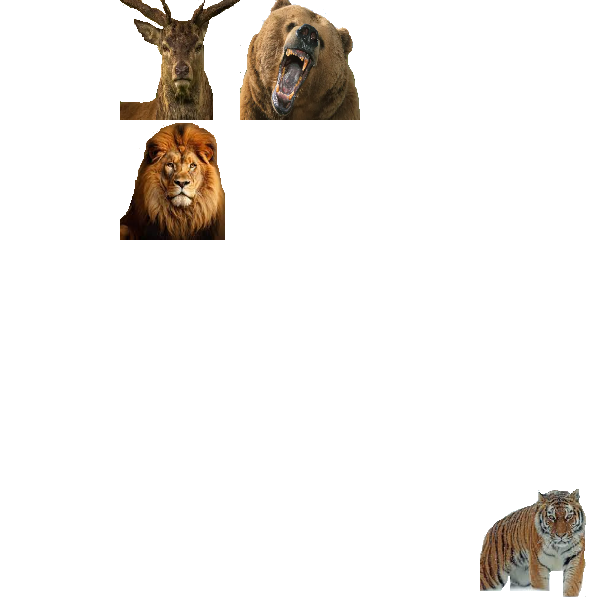

Test PASSED!


In [8]:
# don't change this cell
play_game(variable_elimination, test1)

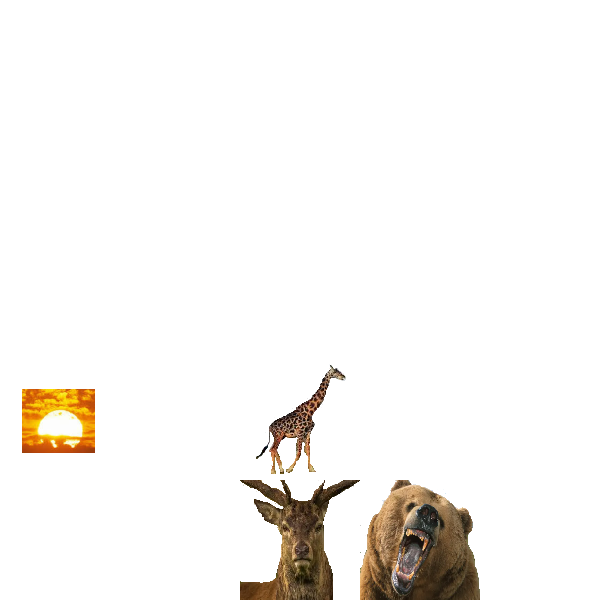

Test PASSED!


In [10]:
# don't change this cell
play_game(variable_elimination, test2)

# **Prior Sampling (25 Points)**

In [25]:

def prior_sampling(input_graph: InputDict) -> str:
    obs = input_graph["observed"]
    evidence = list(map(int, obs.keys()))
    count_evidence = 1
    count_query_5 = 1
    count_query_6 = 1
    while(True):
        s = generate_sample(input_graph)
        not_eq = same_evidence(evidence, obs, s)
        if not_eq:
            continue
        count_evidence += 1
        if s['5']:
            count_query_5 += 1
        if s['6']:
            count_query_6 += 1
        if count_evidence == 423:
            break

    final_destination = get_answer(count_evidence, count_query_5, count_query_6)

    return final_destination[0]


def get_answer(count_evidence, count_query_5, count_query_6):
    prob_right = ["right", count_query_5 / count_evidence]
    prob_down = ["down", count_query_6 / count_evidence]
    prob_left = ["left", 1 - prob_right[1]]
    prob_up = ["up", 1 - prob_down[1]]
    final_destination = max(prob_right, prob_down, prob_left, prob_up, key=lambda x: x[1])
    return final_destination


def same_evidence(evidence, obs, s):
    not_eq = False
    for e in evidence:
        if s[str(e)] != obs[str(e)]:
            not_eq = True
            break
    return not_eq


def get_prob_from_cpt_prior(details, probs):
    p = 1
    parents = details["parents"]
    if parents:
        index = get_index_based_on_parents(parents, probs)
        p *= details["CPT"][index]
    else:
        p *= details["CPT"][0]
    return p


def generate_sample(input_graph):
    probs = {}
    for node, details in input_graph.items():
        if node == "observed":
            continue
        if get_true_with_probability(get_prob_from_cpt_prior(details, probs)):
            probs[node] = True
        else:
            probs[node] = False

    return probs


def get_true_with_probability(p):
    return random.random() < p


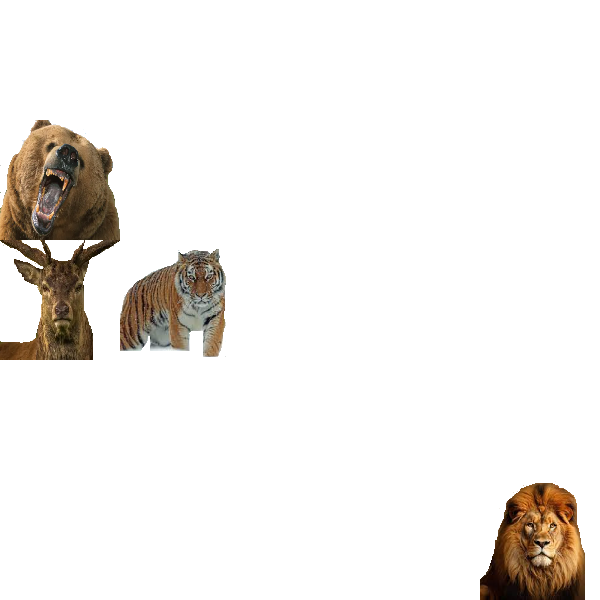

Test PASSED!


In [26]:
# don't change this cell
play_game(prior_sampling, test3)

# **Rejection Sampling (25 Points)**

In [23]:

def rejection_sampling(input_graph: InputDict) -> str:
    obs = input_graph["observed"]
    evidence = list(map(int, obs.keys()))
    count_evidence = 1
    count_query_5 = 1
    count_query_6 = 1
    while(True):
        s = generate_sample_and_reject(evidence, obs, input_graph)
        if s[1]:
            continue
        s = s[0]
        not_eq = same_evidence(evidence, obs, s)
        if not_eq:
            continue
        count_evidence += 1
        if s['5']:
            count_query_5 += 1
        if s['6']:
            count_query_6 += 1
        if count_evidence == 423:
            break

    final_destination = get_answer(count_evidence, count_query_5, count_query_6)

    return final_destination[0]


def generate_sample_and_reject(evidence, obs, input_graph):
    probs = {}
    for node, details in input_graph.items():
        if node == "observed":
            continue
        if get_true_with_probability(get_prob_from_cpt_prior(details, probs)):
            probs[node] = True
        else:
            probs[node] = False
        if node in evidence:
            if obs[node] != probs[node]:
                return probs, True

    return probs, False


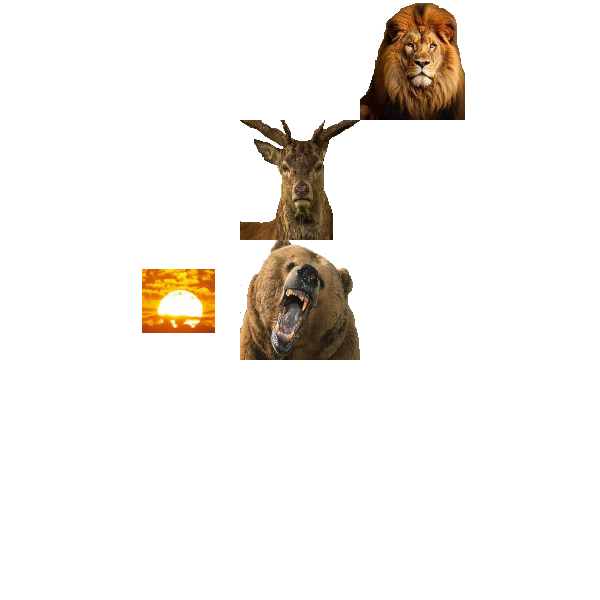

Test PASSED!


In [24]:
# don't change this cell
play_game(rejection_sampling, test4)